In [1]:
!pip install rouge

In [2]:
import tensorflow as tf
import numpy as np
import os
from google.colab import drive
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense,Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import sentence_bleu,SmoothingFunction
from rouge import Rouge
from tensorflow.keras.models import load_model


In [5]:
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
glove_path = '/content/drive/My Drive/datasetfiles/glove.6B.100d.txt'
merged_clean_dataset='/content/drive/My Drive/datasetfiles/merged_dataset.txt'
merged_embeddings='/content/drive/My Drive/datasetfiles/merged-embeddings.txt'


#Model 1- RNN architecture with pre-trained Glove word embeddings

In [12]:
# Load merged dataset
with open(merged_clean_dataset, 'r', encoding='utf-8') as f:
    text_data = f.read()

# Tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts([text_data])
sequences = tokenizer.texts_to_sequences([text_data])[0]

vocab_size = len(tokenizer.word_index) + 1

sequence_length = 5
input_sequences = []
output_words = []

for i in range(sequence_length, len(sequences)):
    input_sequences.append(sequences[i-sequence_length:i])
    output_words.append(sequences[i])

input_sequences = np.array(input_sequences)
output_words = np.array(output_words)

# Split into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(input_sequences, output_words, test_size=0.2, random_state=42)
print(f"Training data shape: {X_train.shape}, Validation data shape: {X_val.shape}")


Training data shape: (3600, 5), Validation data shape: (900, 5)


In [13]:
# Load GloVe embeddings
embedding_dim = 100
embedding_index = {}

with open(glove_path, 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

# Create embedding matrix
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [14]:

model = Sequential([
    Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], trainable=False, input_length=sequence_length),
    LSTM(128, return_sequences=True, dropout=0.3),
    LSTM(128, dropout=0.3),
    Dense(vocab_size, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:


history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=64)
model.save("model1_checkpoint.h5")

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1271/1271 ━━━━━━━━━━━━━━━━━━━━ 90s 67ms/step - accuracy: 0.0717 - loss: 7.2603 - val_accuracy: 0.1118 - val_loss: 6.5570
Epoch 2/20
1271/1271 ━━━━━━━━━━━━━━━━━━━━ 145s 70ms/step - accuracy: 0.1285 - loss: 6.1816 - val_accuracy: 0.1602 - val_loss: 5.9939
Epoch 3/20
1271/1271 ━━━━━━━━━━━━━━━━━━━━ 82s 65ms/step - accuracy: 0.1753 - loss: 5.5326 - val_accuracy: 0.1917 - val_loss: 5.6721
Epoch 4/20
1271/1271 ━━━━━━━━━━━━━━━━━━━━ 142s 65ms/step - accuracy: 0.2119 - loss: 5.0157 - val_accuracy: 0.2240 - val_loss: 5.4062
Epoch 5/20
1271/1271 ━━━━━━━━━━━━━━━━━━━━ 142s 64ms/step - accuracy: 0.2479 - loss: 4.5585 - val_accuracy: 0.2484 - val_loss: 5.2834
Epoch 6/20
1271/1271 ━━━━━━━━━━━━━━━━━━━━ 146s 67ms/step - accuracy: 0.2781 - loss: 4.1938 - val_accuracy: 0.2659 - val_loss: 5.1957
Epoch 7/20
1271/1271 ━━━━━━━━━━━━━━━━━━━━ 141s 67ms/step - accuracy: 0.3027 - loss: 3.8734 - val_accuracy: 0.2755 - val_loss: 5.1816
Epoch 8/20
1271/1271 ━━━━━━━━━━━━━━━━━━━━ 84s 66ms/step - accuracy: 0.3282 - loss:

In [ ]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 5, 100)              │         934,900 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 5, 128)              │         117,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ (None, 128)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 9349)                │       1,206,021 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,299,461 (20.22 MB)

 Trainable params: 1,454,853 (5.55 MB)

 Non-trainable params: 934,900 (3.57 MB)

 Optimizer params: 2,909,708 (11.10 MB)

In [ ]:
model.save('/content/drive/MyDrive/datasetfiles/model1_rnn.h5')

In [ ]:
# Average training accuracy and loss
overall_train_accuracy = sum(history.history['accuracy']) / len(history.history['accuracy'])
overall_train_loss = sum(history.history['loss']) / len(history.history['loss'])

# Average validation accuracy and loss
overall_val_accuracy = sum(history.history['val_accuracy']) / len(history.history['val_accuracy'])
overall_val_loss = sum(history.history['val_loss']) / len(history.history['val_loss'])

print(f"Training Accuracy: {overall_train_accuracy:.4f}")
print(f"Validation Accuracy: {overall_val_accuracy:.4f}")
print(f"Training Loss: {overall_train_loss:.4f}")
print(f"Validation Loss: {overall_val_loss:.4f}")


Training Accuracy: 0.3854
Validation Accuracy: 0.2690
Training Loss: 3.4438
Validation Loss: 5.5692


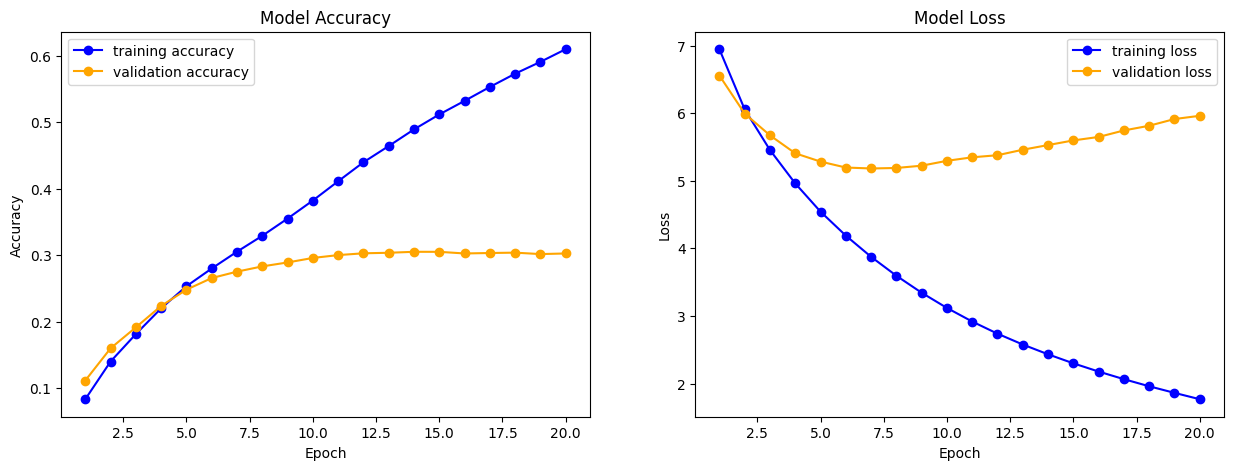

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
history_mn=history
# summarize history for accuracy
axs[0].plot(range(1, len(history_mn.history['accuracy']) + 1), history_mn.history['accuracy'], marker='o', color='blue')
axs[0].plot(range(1, len(history_mn.history['val_accuracy']) + 1), history_mn.history['val_accuracy'], marker='o', color='orange')
axs[0].set_title('Model Accuracy')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epoch')

axs[0].legend(['training accuracy', 'validation accuracy'], loc='best')

# summarize history for loss
axs[1].plot(range(1, len(history_mn.history['loss']) + 1), history_mn.history['loss'], marker='o', color='blue')
axs[1].plot(range(1, len(history_mn.history['val_loss']) + 1), history_mn.history['val_loss'], marker='o', color='orange')
axs[1].set_title('Model Loss')
axs[1].set_ylabel('Loss')
axs[1].set_xlabel('Epoch')

axs[1].legend(['training loss', 'validation loss'], loc='best')

plt.show()


#Model 2 - RNN architecture with Self-Generated embeddings

In [15]:

embedding_index = {}

# Read the embeddings file
with open(merged_embeddings, "r", encoding="utf-8") as f:
    for line in f:
        # Skip empty lines or lines that do not contain enough values
        values = line.split()
        if len(values) < 2:
            continue  # Skip lines that don't have at least one word and one vector

        word = values[0]
        vector = np.array(values[1:], dtype="float32")
        embedding_index[word] = vector

print(f"Loaded {len(embedding_index)} word vectors.")


Loaded 8707 word vectors.


In [16]:

embedding_dim = 30

# Initialize embedding matrix with zeros
embedding_matrix = np.zeros((vocab_size, embedding_dim))

# Populate the embedding matrix
for word, i in tokenizer.word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector


In [17]:
# embedding_matrix is generated using Assignment 2 embeddings
model2 = Sequential([
    Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], trainable=False, input_length=sequence_length),
    LSTM(128, return_sequences=True, dropout=0.3),
    LSTM(128, dropout=0.3),
    Dense(vocab_size, activation='softmax')
])

model2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Train Model 2
history2 = model2.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=64)
model2.save('/content/drive/MyDrive/datasetfiles/model2_rnn.h5')

Epoch 1/20
1271/1271 ━━━━━━━━━━━━━━━━━━━━ 87s 68ms/step - accuracy: 0.0920 - loss: 6.5582 - val_accuracy: 0.1020 - val_loss: 6.4614
Epoch 2/20
1271/1271 ━━━━━━━━━━━━━━━━━━━━ 137s 65ms/step - accuracy: 0.1081 - loss: 6.1581 - val_accuracy: 0.1209 - val_loss: 6.2569
Epoch 3/20
1271/1271 ━━━━━━━━━━━━━━━━━━━━ 140s 63ms/step - accuracy: 0.1234 - loss: 5.8384 - val_accuracy: 0.1347 - val_loss: 6.1089
Epoch 4/20
1271/1271 ━━━━━━━━━━━━━━━━━━━━ 81s 64ms/step - accuracy: 0.1365 - loss: 5.5702 - val_accuracy: 0.1541 - val_loss: 6.0263
Epoch 5/20
1271/1271 ━━━━━━━━━━━━━━━━━━━━ 85s 67ms/step - accuracy: 0.1536 - loss: 5.3112 - val_accuracy: 0.1690 - val_loss: 5.9593
Epoch 6/20
1271/1271 ━━━━━━━━━━━━━━━━━━━━ 147s 71ms/step - accuracy: 0.1621 - loss: 5.1167 - val_accuracy: 0.1774 - val_loss: 5.9314
Epoch 7/20
1271/1271 ━━━━━━━━━━━━━━━━━━━━ 133s 64ms/step - accuracy: 0.1723 - loss: 4.9478 - val_accuracy: 0.1849 - val_loss: 5.9258
Epoch 8/20
1271/1271 ━━━━━━━━━━━━━━━━━━━━ 82s 64ms/step - accuracy: 0.18

In [ ]:
model2.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)              │ (None, 5, 30)               │         280,470 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_9 (LSTM)                        │ (None, 5, 128)              │          81,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_10 (LSTM)                       │ (None, 128)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 9349)                │       1,206,021 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,537,511 (17.31 MB)

 Trainable params: 1,419,013 (5.41 MB)

 Non-trainable params: 280,470 (1.07 MB)

 Optimizer params: 2,838,028 (10.83 MB)

In [ ]:
# Average training accuracy and loss
overall_train_accuracy = sum(history2.history['accuracy']) / len(history2.history['accuracy'])
overall_train_loss = sum(history2.history['loss']) / len(history2.history['loss'])

# Average validation accuracy and loss
overall_val_accuracy = sum(history2.history['val_accuracy']) / len(history2.history['val_accuracy'])
overall_val_loss = sum(history2.history['val_loss']) / len(history2.history['val_loss'])

print(f"Overall Training Accuracy: {overall_train_accuracy:.4f}")
print(f"Overall Validation Accuracy: {overall_val_accuracy:.4f}")
print(f"Overall Training Loss: {overall_train_loss:.4f}")
print(f"Overall Validation Loss: {overall_val_loss:.4f}")


Overall Training Accuracy: 0.1917
Overall Validation Accuracy: 0.1912
Overall Training Loss: 4.7428
Overall Validation Loss: 6.0408


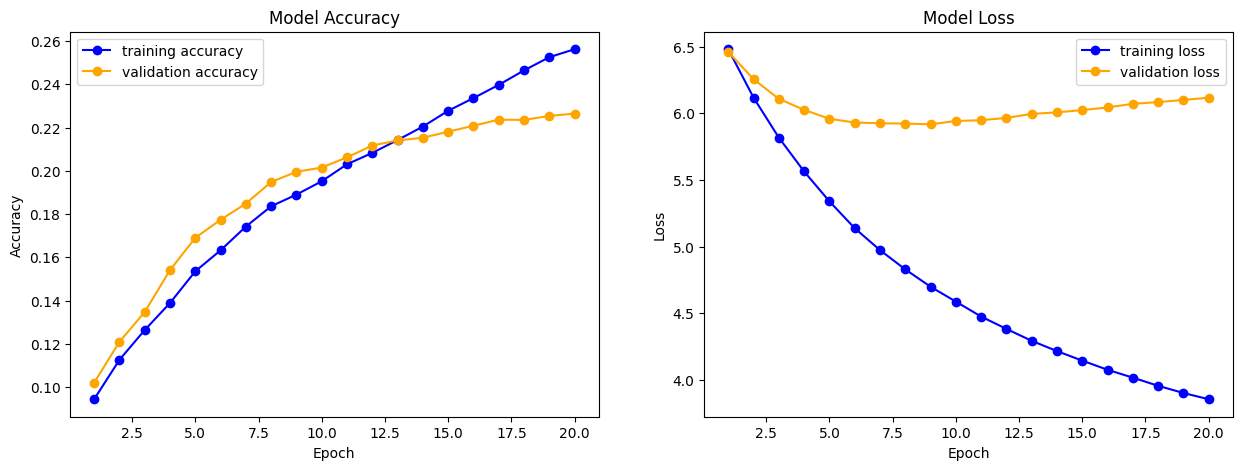

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
history_mn=history2
# summarize history for accuracy
axs[0].plot(range(1, len(history_mn.history['accuracy']) + 1), history_mn.history['accuracy'], marker='o', color='blue')
axs[0].plot(range(1, len(history_mn.history['val_accuracy']) + 1), history_mn.history['val_accuracy'], marker='o', color='orange')
axs[0].set_title('Model Accuracy')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epoch')

axs[0].legend(['training accuracy', 'validation accuracy'], loc='best')

# summarize history for loss
axs[1].plot(range(1, len(history_mn.history['loss']) + 1), history_mn.history['loss'], marker='o', color='blue')
axs[1].plot(range(1, len(history_mn.history['val_loss']) + 1), history_mn.history['val_loss'], marker='o', color='orange')
axs[1].set_title('Model Loss')
axs[1].set_ylabel('Loss')
axs[1].set_xlabel('Epoch')

axs[1].legend(['training loss', 'validation loss'], loc='best')

plt.show()


#Evaluation

In [18]:
def generate_next_words(model, tokenizer, input_text, sequence_length, num_words):
    generated_text = input_text
    for _ in range(num_words):
        # Tokenize and pad the input text
        sequence = tokenizer.texts_to_sequences([generated_text])
        padded_sequence = pad_sequences(sequence, maxlen=sequence_length, padding='pre')

        # Predict the next word
        prediction = model.predict(padded_sequence)
        predicted_word_idx = np.argmax(prediction, axis=-1)
        predicted_word = tokenizer.index_word.get(predicted_word_idx[0], "")

        # Append the predicted word to the generated text
        generated_text += " " + predicted_word
    return generated_text

# Example input for evaluation
sample_input = "How to"

# Generate outputs for Model 1 and Model 2
model1_generated = generate_next_words(model, tokenizer, sample_input, sequence_length=10, num_words=30)
model2_generated = generate_next_words(model2, tokenizer, sample_input, sequence_length=10, num_words=30)

print(f"Model 1 Generated Sequence: {model1_generated}")
print(f"Model 2 Generated Sequence: {model2_generated}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━

In [19]:
# Function to compute BLEU score
def compute_bleu(reference, generated_text):
    # Tokenize reference and generated text into words
    reference = reference.split()  # Reference is the actual text, tokenized into words
    generated_text = generated_text.split()  # Generated text, tokenized into words

    # Define a smoothing function to prevent zero counts
    smoothing_function = SmoothingFunction().method1

    # Compute BLEU scores for 1-gram to 4-gram
    bleu_score1 = sentence_bleu([reference], generated_text, weights=(1, 0, 0, 0), smoothing_function=smoothing_function)
    bleu_score2 = sentence_bleu([reference], generated_text, weights=(0.5, 0.5, 0, 0), smoothing_function=smoothing_function)
    bleu_score3 = sentence_bleu([reference], generated_text, weights=(0.3, 0.3, 0.3, 0), smoothing_function=smoothing_function)
    bleu_score4 = sentence_bleu([reference], generated_text, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smoothing_function)

    return bleu_score1, bleu_score2, bleu_score3, bleu_score4


# Function to compute ROUGE score
def compute_rouge(reference, prediction):
    rouge = Rouge()
    scores = rouge.get_scores(prediction, reference)
    return scores[0]


In [20]:
# Generate sequences for Model 1 and Model 2
model1_generated = generate_next_words(model, tokenizer, sample_input, sequence_length=10, num_words=30)
model2_generated = generate_next_words(model2, tokenizer, sample_input, sequence_length=10, num_words=30)

# Split generated sequences into reference and prediction
model1_reference = ' '.join(model1_generated.split()[:15])  # First 15 words as reference
model1_prediction = ' '.join(model1_generated.split()[15:])  # Next 15 words as prediction

model2_reference = ' '.join(model2_generated.split()[:15])  # First 15 words as reference
model2_prediction = ' '.join(model2_generated.split()[15:])  # Next 15 words as prediction

# Compute BLEU scores for Model 1
bleu_model1_scores = compute_bleu(model1_reference, model1_prediction)
bleu_model1 = {
    "BLEU-1": bleu_model1_scores[0],
    "BLEU-2": bleu_model1_scores[1],
    "BLEU-3": bleu_model1_scores[2],
    "BLEU-4": bleu_model1_scores[3],
}

# Compute BLEU scores for Model 2
bleu_model2_scores = compute_bleu(model2_reference, model2_prediction)
bleu_model2 = {
    "BLEU-1": bleu_model2_scores[0],
    "BLEU-2": bleu_model2_scores[1],
    "BLEU-3": bleu_model2_scores[2],
    "BLEU-4": bleu_model2_scores[3],
}

# Compute ROUGE scores for both models
rouge_model1 = compute_rouge(model1_reference, model1_prediction)
rouge_model2 = compute_rouge(model2_reference, model2_prediction)

# Print BLEU scores for both models
print(f"Model 1 BLEU Scores:")
print(f"  BLEU-1: {bleu_model1['BLEU-1']:.4f}")
print(f"  BLEU-2: {bleu_model1['BLEU-2']:.4f}")
print(f"  BLEU-3: {bleu_model1['BLEU-3']:.4f}")
print(f"  BLEU-4: {bleu_model1['BLEU-4']:.4f}")

print(f"Model 2 BLEU Scores:")
print(f"  BLEU-1: {bleu_model2['BLEU-1']:.4f}")
print(f"  BLEU-2: {bleu_model2['BLEU-2']:.4f}")
print(f"  BLEU-3: {bleu_model2['BLEU-3']:.4f}")
print(f"  BLEU-4: {bleu_model2['BLEU-4']:.4f}")

# Print ROUGE scores for both models
print(f"Model 1 ROUGE Score: {rouge_model1}")
print(f"Model 2 ROUGE Score: {rouge_model2}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━